In [907]:
#import the libraries
import pandas as pd
import numpy as np

In [908]:
# Read the dataset
db = pd.read_csv("diabetes.csv")
db.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [909]:
db.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [910]:
# Replacing 0 values to NaN in columns
columns = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for column in cols:
    db[column].replace(0,np.NaN,inplace=True)

In [911]:
#It gives the numbers of missing NaN's in different cloumns
db.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [912]:
# Replacing the missing NaN values with median based on target i.e. Outcome
for col in db.columns:
    db.loc[(db["Outcome"]==0) & (db[col].isnull()),col] = db[db["Outcome"]==0][col].median()
    db.loc[(db["Outcome"]==1) & (db[col].isnull()),col] = db[db["Outcome"]==1][col].median()

In [913]:
#Now, see the missing values
db.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [914]:
# Dealing with outliers
# Define a function to find the outlier thresholds
# According to data structure, business area different quartiles like 0.1, 0.9 can be selected.
# For linear models, we need to analyse outliers. 

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.10)
    quartile3 = dataframe[variable].quantile(0.90)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# We have defined a function which has_outliers
# It will give the names of the columns having outliers
def has_outliers(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    if dataframe[(dataframe[variable] < low_limit) | (dataframe[variable] > up_limit)].any(axis=None):
        print(variable,"coulmn has outliers")  
        
for col in db.columns:
    has_outliers(db, col)

SkinThickness coulmn has outliers
Insulin coulmn has outliers
DiabetesPedigreeFunction coulmn has outliers


In [915]:
# Replacing the columns values having outliers with lower and upper limits 
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
        dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
        replace_with_thresholds(db, db.columns)
        for col in db.columns:
            has_outliers(db, col)

In [916]:
# For Glucose Tolerance Test(GLT)
# Normal Results for Diabetes -> Two-hour glucose level less than 140 mg/dL
# Impaired Results for Diabetes -> Two-hour glucose level 140 to 200 mg/dL
# Abnormal (Diagnostic) Results for Diabetes -> Two-hour glucose level greater than 200 mg/dL

db['New_GLT'] = pd.cut(x=db['Glucose'], bins=[0,139,200,250],labels = ["Normal","Impaired","Abnormal"])

In [940]:
# BMI
# Below 18.5 -> Underweight
# 18.5 – 24.9 -> Normal or Healthy Weight
# 25.0 – 29.9 -> Overweight
# 30.0 and Above -> Obese

db['New_BMI'] = pd.cut(x=db['BMI'], bins=[0,18.4,24.9,29.9,70],labels = ["Underweight","Healty or Normal","Overweight","Obese"])

In [941]:
# Blood Pressure(BP)
# Normal: Systolic below 120 and diastolic below 80
# Elevated: Systolic 120–129 and diastolic under 80
# Hypertension stage 1(HS1): Systolic 130–139 and diastolic 80–89
# Hypertension stage 2(HS2): Systolic 140-plus and diastolic 90 or more
# Hypertensive crisis(HC): Systolic higher than 180 and diastolic above 120.

db['New_BP'] = pd.cut(x=db['BloodPressure'], bins=[0,79,89,120,150],labels = ["Normal","HS1","HS2","HC"])

In [942]:
# Triceps Skinfolds
# For adults, the standard normal values for triceps skinfolds is 18.0 mm for women

db['New_SThick'] = db['SkinThickness'].apply(lambda x: 1 if x <= 18.0 else 0)
db.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_GLT_Impaired,...,New_BMI_Healty or Normal,New_BMI_Overweight,New_BMI_Obese,New_BP_HS1,New_BP_HS2,New_BP_HC,New_SThick_1,New_BMI,New_BP,New_SThick
0,0.6,0.765,0.000,1.000,1.000,0.170,0.159,1.235,1,1,...,0,0,1,0,0,0,0,Underweight,NaN,1
1,-0.4,-0.790,-0.375,0.143,0.000,-0.599,-0.013,0.118,0,0,...,0,1,0,0,0,0,0,NaN,NaN,1
2,1.0,1.630,-0.500,0.571,1.000,-0.962,0.187,0.176,1,1,...,1,0,0,0,0,0,0,NaN,NaN,1
3,-0.4,-0.691,-0.375,-0.714,-0.127,-0.434,-0.128,-0.471,0,0,...,0,1,0,0,0,0,0,NaN,NaN,1
4,-0.6,0.494,-2.000,1.000,0.978,1.214,1.194,0.235,1,0,...,0,0,1,0,0,0,0,Underweight,NaN,1
5,0.4,-0.025,0.125,-0.143,0.000,-0.709,-0.107,0.059,0,0,...,0,1,0,0,0,0,0,NaN,Normal,1
6,0.0,-0.963,-1.375,0.571,-0.216,-0.115,-0.078,-0.176,1,0,...,0,0,1,0,0,0,0,NaN,NaN,1
7,1.4,-0.049,-0.125,-0.143,0.000,0.357,-0.149,0.000,0,0,...,0,0,1,0,0,0,0,Underweight,NaN,1
8,-0.2,1.975,-0.125,2.429,6.575,-0.170,-0.134,1.412,1,1,...,0,0,1,0,0,0,0,NaN,NaN,1
9,1.0,0.198,1.500,0.571,1.000,0.247,-0.088,1.471,1,0,...,0,0,1,0,1,0,0,Underweight,Normal,1


In [943]:
def one_hot_encoder(dataframe, categorical_columns, nan_as_category=False):
    original_columns = list(dataframe.columns)
    dataframe = pd.get_dummies(dataframe, columns=categorical_columns,
                               dummy_na=nan_as_category, drop_first=True)
    new_columns = [col for col in dataframe.columns if col not in original_columns]
    return dataframe, new_columns

In [944]:
categorical_columns = [col for col in db.columns
                           if len(db[col].unique()) <= 10
                      and col != "Outcome"]
categorical_columns

['New_GLT_Impaired',
 'New_GLT_Abnormal',
 'New_BMI_Healty or Normal',
 'New_BMI_Overweight',
 'New_BMI_Obese',
 'New_BP_HS1',
 'New_BP_HS2',
 'New_BP_HC',
 'New_SThick_1',
 'New_BMI',
 'New_BP',
 'New_SThick']

In [945]:
db, new_cols_ohe = one_hot_encoder(db,categorical_columns)
new_cols_ohe

['New_GLT_Impaired_1',
 'New_BMI_Healty or Normal_1',
 'New_BMI_Overweight_1',
 'New_BMI_Obese_1',
 'New_BP_HS1_1',
 'New_BP_HS2_1',
 'New_BP_HC_1',
 'New_SThick_1_1']

In [946]:
from sklearn.preprocessing import RobustScaler
def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        if int(interquantile_range) == 0:
            quartile1 = variable.quantile(0.01)
            quartile3 = variable.quantile(0.99)
            interquantile_range = quartile3 - quartile1
            z = (variable - var_median) / interquantile_range
            return round(z, 3)

        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)

like_num = [col for col in db.columns if db[col].dtypes != 'O' and len(db[col].value_counts()) < 10]
cols_need_scale = [col for col in db.columns if col not in new_cols_ohe
                   and col not in "Outcome"
                   and col not in like_num]

for col in cols_need_scale:
    db[col] = robust_scaler(db[col])

In [947]:
# Principal_Component_Analysis
 
def PCA(X,num_components):
     
    #Step-1 : centralize the data values around mean
    X_mean = X - np.mean(X , axis = 0)
     
    #Step-2:calculate the covariance matrix
    covariance_matrix = np.cov(X_mean , rowvar = False)
     
    #Step-3: calculate the list of eigen values and eigen vectors
    eigen_values , eigen_vectors = np.linalg.eigh(covariance_matrix)
     
    #Step-4: Sort the eigen values and eigen vectors in desecensing order
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5 : Sorting the eigen vectors based on number of components
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6: transform the data
    X_reduced = np.dot(eigenvector_subset.transpose() , X_mean.transpose() ).transpose()
     
    return X_reduced

In [948]:
#prepare the data
X = db.drop(['Outcome'],axis =1)
#prepare the target
Y = db['Outcome']

In [949]:
#split the dataset into train and test 
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.20, random_state = 42)
# split the training data into training and validation set
X_train1,X_val,Y_train1,Y_val = train_test_split(X_train,Y_train,test_size = 0.125 ,random_state = 42)

In [950]:
#Applying it to PCA function
mat_reduced = PCA(X_train1,2)
#Creating a Pandas DataFrame of reduced Dataset
principal_db = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])
#Concat it with target variable to create a complete Dataset
principal_db = pd.concat([principal_db , pd.DataFrame(Y)] , axis = 1)

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

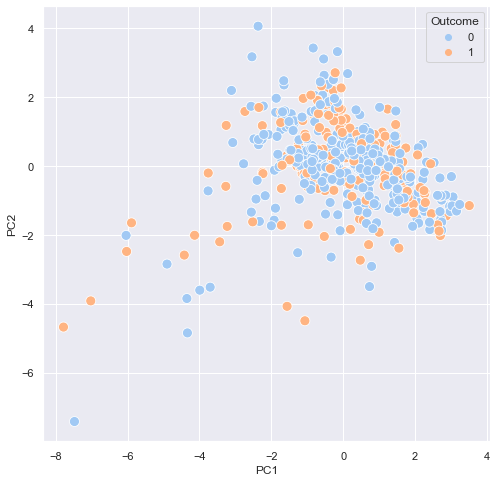

In [962]:
import seaborn as sb
import matplotlib.pyplot as plt
plt.figure(figsize = (8,8))
sb.scatterplot(data = principal_db , x = 'PC1',y = 'PC2' , hue = 'Outcome' , s = 100 , palette= 'pastel')

In [963]:
#import the important libraries
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Normalize Features
scaler = StandardScaler()
scaler.fit(principal_db)
pricipal_db = scaler.transform(principal_db)

In [964]:
# SVM Kernels( Accuracy on training dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(principal_db, Y_train1)
    y_pred = model.predict(principal_db)
    print(k)
    print(accuracy_score(Y_train1, y_pred)) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [965]:
# Using the best model
model = svm.SVC(kernel='rbf')
model.fit(X_train1, Y_train1)

SVC()

In [955]:
# SVM Kernels(Accuracy on validation set)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_val, Y_val)
    y_pred1 = model.predict(X_val)
    print(k)
    print(accuracy_score(Y_val, y_pred1))

linear
0.8701298701298701
poly
0.8831168831168831
rbf
0.9090909090909091
sigmoid
0.7922077922077922


In [956]:
# SVM Kernels( Accuracy on test dataset)
for k in ('linear', 'poly', 'rbf', 'sigmoid'):
    model = svm.SVC(kernel=k)
    model.fit(X_test, Y_test)
    y_pred2 = model.predict(X_test)
    print(k)
    print(accuracy_score(Y_test, y_pred2))

linear
0.8766233766233766
poly
0.8766233766233766
rbf
0.935064935064935
sigmoid
0.7922077922077922


In [957]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier


models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [630]:
results = []
names = []
for name,model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_result = model_selection.cross_val_score(model,X_train1,Y_train1, cv = kfold,scoring = "accuracy")
    kfold = model_selection.KFold(n_splits=10)
    names.append(name)
    results.append(cv_result)
for i in range(len(names)):
    print(names[i],results[i].mean())

LR 0.7616352201257861
LDA 0.7541579315164221
KNN 0.7616002795248079
CART 0.8567784765897974
RF 0.88277428371768
NB 0.7278476589797345
SVM 0.7877707896575821


[Text(0, 0, 'LR'),
 Text(1, 0, 'LDA'),
 Text(2, 0, 'KNN'),
 Text(3, 0, 'CART'),
 Text(4, 0, 'RF'),
 Text(5, 0, 'NB'),
 Text(6, 0, 'SVM')]

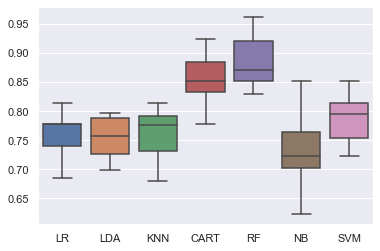

In [631]:
ax = sns.boxplot(data=results)
ax.set_xticklabels(names)

In [632]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train1,Y_train1)
predictions_lda = lda.predict(X_val)

In [633]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 

In [634]:
print("Accuracy Score is:")
print(accuracy_score(Y_val, predictions_lda))
print()

Accuracy Score is:
0.8181818181818182



In [635]:
print("Classification Report:")
print(classification_report(Y_val, predictions_lda))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        53
           1       0.69      0.75      0.72        24

    accuracy                           0.82        77
   macro avg       0.79      0.80      0.79        77
weighted avg       0.82      0.82      0.82        77



In [636]:
conf = confusion_matrix(Y_val,predictions_lda)
conf

array([[45,  8],
       [ 6, 18]], dtype=int64)

<AxesSubplot:>

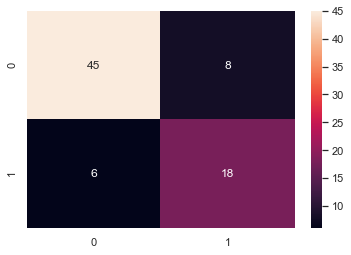

In [637]:
label = ["0","1"]
sns.heatmap(conf, annot=True, xticklabels=label, yticklabels=label)